In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utilsCPD import *
import matplotlib.pyplot as plt
from SWCPD import BaseDetector as SWDCP
from claspy.segmentation import BinaryClaSPSegmentation


3.7817059379947895
-3.238411383218804
0.5555016654909525
4.091785938364422
-3.7380275398351994
-0.11950753909439105


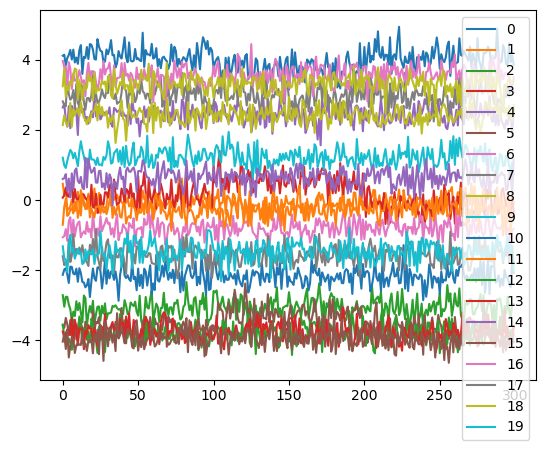

In [2]:
def make_dynamic_blobs(n_samples, base_center, n_clusters, varying_features, 
                       cluster_std=1.0, center_offset_range=(-5, 5), random_state=None):
    """
    Generate synthetic data with dynamic centers based on a base center and random offsets.
    
    Parameters:
        n_samples: int
            Total number of samples.
        base_center: array-like
            The center of the first cluster. Shape: (n_features,).
        n_clusters: int
            Number of clusters to generate.
        varying_features: list of int
            Indices of features that should vary across clusters.
        cluster_std: float
            Standard deviation of clusters.
        center_offset_range: tuple
            Range (min, max) for random uniform offsets added to the base center for varying features.
        random_state: int or None
            Random seed for reproducibility.
    
    Returns:
        X: ndarray of shape (n_samples, n_features)
            The generated samples.
        y: ndarray of shape (n_samples,)
            The integer labels for cluster membership.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_features = len(base_center)
    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters

    # Generate cluster centers
    centers = [np.array(base_center,dtype=float)]
    for _ in range(1, n_clusters):
        new_center = centers[0].copy()  # Start with the base center
        for feature in varying_features:
        
            new_center[feature] +=  np.random.uniform(*center_offset_range)
            print(new_center[feature])
            
        centers.append(new_center)
    centers = np.array(centers)
    
    # Generate points for each cluster
    X = []
    y = []
    for cluster_idx, center in enumerate(centers):
        cluster_size = samples_per_cluster + (1 if cluster_idx < remainder else 0)
        cluster_points = np.random.normal(
            loc=center,
            scale=cluster_std,
            size=(cluster_size, n_features)
        )
        X.append(cluster_points)
        y.extend([cluster_idx] * cluster_size)
    
    X = np.vstack(X)
    y = np.array(y)
    
    return X.astype(np.float32), y, centers

# Example Usage
base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster
n_clusters = 3
n_samples = 300
varying_features = [0,5,3]#[0,5,3]#, 1,4,5,6]  # Only the first two features vary
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.25, 
    center_offset_range=(-0.5, 0.5), 
    random_state=2025
)

fig, ax = plt.subplots()
pd.DataFrame(X).plot(ax=ax,legend=True)



def detection_delay(gt, pred):
    """Compute detection delay for each predicted CP.
    
    Args:
        T (set): Ground truth CPs (annotations).
        X (set): Predicted CPs.

    Returns:
        delays (dict): {prediction: detection delay}
        avg_delay (float): Mean detection delay
    """
    T = set(gt)
    X = set(pred)
    delays = {}
    for x in X:
        if T:  # Ensure T is not empty
            closest_t = min(T, key=lambda t: abs(x - t))  # Find closest annotation
            delays[x] = abs(x - closest_t)  # Compute delay
    
    avg_delay = np.mean(list(delays.values())) if delays else 0  # Mean delay
    return delays, avg_delay


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    TP = false_positives(Tstar,X,margin=margin)
    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F, auc([0,R,1.0],[1.0,P,0]),len(false_positives(Tstar,X,margin=margin))



def true_positives(T, X, margin=5):
    """Compute true positives without double counting

    >>> true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> true_positives(set(), {1, 2, 3})
    set()
    >>> true_positives({1, 2, 3}, set())
    set()
    """
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP

# def false_positives(T, X, margin=5):
#     """Returns a set of false positives (incorrectly predicted CPs)."""
#     TP = true_positives(T, X, margin)
#     return X - TP  # FP = All Predictions - True Positives
def false_positives(T, X, margin=5):
    """Compute false positives (predictions that don't match any true CPs within margin)."""
    FP = set()
    for x in X:
        if not any(abs(x - t) <= margin for t in T):  # No match within margin
            FP.add(x)
    return FP

In [3]:
base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

In [14]:
random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC & FP':[],'Covering':[],'DD':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=sigma, 
            center_offset_range=(-3, 3), 
            random_state=rs
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        #detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        clasp = BinaryClaSPSegmentation(window_size=100,n_segments=3).fit(df.astype(np.float64))
        print(clasp.change_points)
        #print(detector.device)
        #detector.process_dataloader(p=2,n_theta=5000,explanations=False)

        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},clasp.change_points,margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC & FP'].append(TMP)
        RUN_STATS[str(sigma)]['DD'].append(detection_delay(GroundTruth,clasp.change_points)[1])
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},clasp.change_points,n_obs=df.shape[0]))
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS

2020 0.1
-0.6068109441506992
1.1664091772483838
4.634887998100701
-4.893457631627838
-2.052430131199763
2.878140438372757
[ 500 1000]
[]
2021 0.1
-2.8886022444758632
0.32627366948544534
2.410097788641604
-4.64843341419217
1.9095171903663681
2.3453891007849754
[ 500 1000]
[]
2022 0.1
-6.468320234473704
-1.079595632563616
2.256716987880222
-6.224627808254509
0.03850306778300627
4.498343257565594
[ 500 1000]
[]
2023 0.1
-4.592542093368485
1.268592213061341
5.104728380974054
-5.764895356294544
-3.22589516222643
4.383788401920406
[ 500 1000]
[]
2024 0.1
-2.9963848039479046
0.12070998841395131
2.705326608502247
-6.261620534839103
-2.843828783309811
2.2127920951288056
[ 500 1000]
[]
2020 0.5
-0.6068109441506992
1.1664091772483838
4.634887998100701
-4.893457631627838
-2.052430131199763
2.878140438372757
[ 500 1000]
[]
2021 0.5
-2.8886022444758632
0.32627366948544534
2.410097788641604
-4.64843341419217
1.9095171903663681
2.3453891007849754
[ 500 1000]
[]
2022 0.5
-6.468320234473704
-1.079595632

{'0.1': {'F1 & AUC & FP': [{'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0),
    '20': (0.5, 0.6666666666666667, 0)},
   {'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0),
    '20': (0.5, 0.6666666666666667, 0)},
   {'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0),
    '20': (0.5, 0.6666666666666667, 0)},
   {'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0),
    '20': (0.5, 0.6666666666666667, 0)},
   {'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0),
    '20': (0.5, 0.6666666666666667, 0)}],
  'Covering': [0.3333333333333333,
   0.3333333333333333,
   0.3333333333333333,
   0.3333333333333333,
   0.3333333333333333],
  'DD': [0, 0, 0, 0, 0]},
 '0.5': {'F1 & AUC & FP': [{'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0),
    '20': (0.5, 0.6666666666666667, 0)},
   {'5': (0.5, 0.6666666666666667, 0),
    '10': (0.5, 0.6666666666666667, 0)

In [16]:
import ruptures as rpt 

In [ ]:
random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]
SUMMARY = {}
METRICS = []
#METRICS[rs] = {}
for pen in [1,10,100]:
    RUN_STATS = {}
    for sigma in SIGMA:
        RUN_STATS[str(sigma)] = {'F1 & AUC & FP':[],'Covering':[],'DD':[]}
        for rs in random_states:
            print(rs,sigma)
            #RUN_STATS[sigma] = {}
            X, y, centers = make_dynamic_blobs(
                n_samples=n_samples, 
                base_center=base_center, 
                n_clusters=n_clusters, 
                varying_features=varying_features, 
                cluster_std=sigma, 
                center_offset_range=(-3, 3), 
                random_state=rs
            )
            df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
            print(GroundTruth)
            #serialize_dict(df,GroundTruth,str(sigma)+"-"+str(rs))
            #detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
            algo_c = rpt.KernelCPD(kernel="rbf", min_size=2).fit(
            df.astype(np.float64)
            ) 
            penalty_value = 1 # beta
            cps_KCPA_PELT = algo_c.predict(pen=penalty_value)
            cps = np.array(cps_KCPA_PELT)[:-1]
            print(cps)        #detector.process_dataloader(p=2,n_theta=5000,explanations=False)

            TMP = {}
            for margin in [5,10,20]:
                TMP[str(margin)] = f_measure({'0':GroundTruth},cps,margin=margin)
            RUN_STATS[str(sigma)]['F1 & AUC & FP'].append(TMP)
            RUN_STATS[str(sigma)]['DD'].append(detection_delay(GroundTruth,cps)[1])
            RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},cps,n_obs=df.shape[0]))

        print(RUN_STATS)
        #METRICS.append(RUN_STATS)
    SUMMARY[str(pen)] = RUN_STATS

2020 0.1
-0.6068109441506992
1.1664091772483838
4.634887998100701
-4.893457631627838
-2.052430131199763
2.878140438372757
[ 500 1000]
[ 500 1000]
2021 0.1
-2.8886022444758632
0.32627366948544534
2.410097788641604
-4.64843341419217
1.9095171903663681
2.3453891007849754
[ 500 1000]
[ 500 1000]
2022 0.1
-6.468320234473704
-1.079595632563616
2.256716987880222
-6.224627808254509
0.03850306778300627
4.498343257565594
[ 500 1000]
[ 500 1000]
2023 0.1
-4.592542093368485
1.268592213061341
5.104728380974054
-5.764895356294544
-3.22589516222643
4.383788401920406
[ 500 1000]
[ 500 1000]
2024 0.1
-2.9963848039479046
0.12070998841395131
2.705326608502247
-6.261620534839103
-2.843828783309811
2.2127920951288056
[ 500 1000]
[ 500 1000]
{'0.1': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}, {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}, {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}, {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.

In [48]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)
    

def serialize_dict(data,cps,name):
    Out = {'d':data,'cp':cps}
    with open(name+'.json', 'w', encoding='utf-8') as f:
        json.dump(Out, f, ensure_ascii=False, indent=4,cls=NumpyEncoder)

In [ ]:
serialize_dict(df,GroundTruth,str(sigma)+"-"+str(rs))

In [53]:
RUN_STATS = SUMMARY['100']

grouped = {}

for d in RUN_STATS['0.1']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(0.1,pd.DataFrame(grouped).describe())


for d in RUN_STATS['0.5']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(0.5,pd.DataFrame(grouped).describe())



for d in RUN_STATS['1']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(1,pd.DataFrame(grouped).describe())

0.1          5   10   20
count  5.0  5.0  5.0
mean   1.0  1.0  1.0
std    0.0  0.0  0.0
min    1.0  1.0  1.0
25%    1.0  1.0  1.0
50%    1.0  1.0  1.0
75%    1.0  1.0  1.0
max    1.0  1.0  1.0
0.5           5    10    20
count  10.0  10.0  10.0
mean    1.0   1.0   1.0
std     0.0   0.0   0.0
min     1.0   1.0   1.0
25%     1.0   1.0   1.0
50%     1.0   1.0   1.0
75%     1.0   1.0   1.0
max     1.0   1.0   1.0
1                5         10         20
count  15.000000  15.000000  15.000000
mean    0.978333   0.978333   0.978333
std     0.058909   0.058909   0.058909
min     0.800000   0.800000   0.800000
25%     1.000000   1.000000   1.000000
50%     1.000000   1.000000   1.000000
75%     1.000000   1.000000   1.000000
max     1.000000   1.000000   1.000000


In [54]:
print(0.1,np.mean(RUN_STATS['0.1']['DD']),np.min(RUN_STATS['0.1']['DD']),np.max(RUN_STATS['0.1']['DD']))
print(0.5,np.mean(RUN_STATS['0.5']['DD']),np.min(RUN_STATS['0.5']['DD']),np.max(RUN_STATS['0.5']['DD']))
print(1,np.mean(RUN_STATS['1']['DD']),np.min(RUN_STATS['1']['DD']),np.max(RUN_STATS['1']['DD']))

0.1 0.0 0.0 0.0
0.5 0.0 0.0 0.0
1 40.9 0.0 198.5


In [ ]:
#### E-div
with open("./R/res/Synthetic01ECP.json") as f:
    res = json.load(f)
RES = {}

for margin in [5,10,20]:
    a = []
    fp = []
    dd =  []
    cov = []
    for k,val in res.items():
        pred_cps = val[1:-1]
        #print(pred_cps)
        l,m,n = f_measure({'0':GroundTruth},pred_cps,margin)
        a.append(m)
        fp.append(n)
        cov.append(covering({'0':GroundTruth},pred_cps,1500))
        dd.append(detection_delay(GroundTruth,pred_cps)[1])
    RES[margin] = {'AUC':a,'FP':fp,'DD':dd,'COV':cov}
    #print(RES[margin])
print(0.1)
print(pd.DataFrame(RES[5]).describe())
print(pd.DataFrame(RES[10]).describe())
print(pd.DataFrame(RES[20]).describe())

with open("./R/res/Synthetic05ECP.json") as f:
    res = json.load(f)
RES = {}

for margin in [5,10,20]:
    a = []
    fp = []
    dd =  []
    cov = []
    for k,val in res.items():
        pred_cps = val[1:-1]
        #print(pred_cps)
        l,m,n = f_measure({'0':GroundTruth},pred_cps,margin)
        a.append(m)
        fp.append(n)
        cov.append(covering({'0':GroundTruth},pred_cps,1500))
        dd.append(detection_delay(GroundTruth,pred_cps)[1])
    RES[margin] = {'AUC':a,'FP':fp,'DD':dd,'COV':cov}
    #print(RES[margin])
print(0.5)
print(pd.DataFrame(RES[5]).describe())
print(pd.DataFrame(RES[10]).describe())
print(pd.DataFrame(RES[20]).describe())



with open("./R/res/Synthetic1ECP.json") as f:
    res = json.load(f)
RES = {}

for margin in [5,10,20]:
    a = []
    fp = []
    dd =  []
    cov = []
    for k,val in res.items():
        pred_cps = val[1:-1]
        #print(pred_cps)
        l,m,n = f_measure({'0':GroundTruth},pred_cps,margin)
        a.append(m)
        fp.append(n)
        cov.append(covering({'0':GroundTruth},pred_cps,1500))
        dd.append(detection_delay(GroundTruth,pred_cps)[1])
    RES[margin] = {'AUC':a,'FP':fp,'DD':dd,'COV':cov}
    #print(RES[margin])
print(1.0)
print(pd.DataFrame(RES[5]).describe())
print(pd.DataFrame(RES[10]).describe())
print(pd.DataFrame(RES[20]).describe())

0.1
            AUC        FP          DD       COV
count  5.000000  5.000000    5.000000  5.000000
mean   0.950000  0.400000   30.600000  0.965471
std    0.068465  0.547723   50.810323  0.045520
min    0.875000  0.000000    1.000000  0.899337
25%    0.875000  0.000000    1.000000  0.936004
50%    1.000000  0.000000    1.000000  0.997337
75%    1.000000  1.000000   31.666667  0.997337
max    1.000000  1.000000  118.333333  0.997337
            AUC        FP          DD       COV
count  5.000000  5.000000    5.000000  5.000000
mean   0.950000  0.400000   30.600000  0.965471
std    0.068465  0.547723   50.810323  0.045520
min    0.875000  0.000000    1.000000  0.899337
25%    0.875000  0.000000    1.000000  0.936004
50%    1.000000  0.000000    1.000000  0.997337
75%    1.000000  1.000000   31.666667  0.997337
max    1.000000  1.000000  118.333333  0.997337
            AUC        FP          DD       COV
count  5.000000  5.000000    5.000000  5.000000
mean   0.950000  0.400000   30.60000

In [89]:
#### E-div
with open("./R/res/Synthetic01BOCPD.json") as f:
    res = json.load(f)
RES = {}

for margin in [5,10,20]:
    a = []
    fp = []
    dd =  []
    cov = []
    for k,val in res.items():
        pred_cps = val[0][1:]
        #print(pred_cps)
        l,m,n = f_measure({'0':GroundTruth},pred_cps,margin)
        a.append(m)
        fp.append(n)
        cov.append(covering({'0':GroundTruth},pred_cps,1500))
        dd.append(detection_delay(GroundTruth,pred_cps)[1])
    RES[margin] = {'AUC':a,'FP':fp,'DD':dd,'COV':cov}
    #print(RES[margin])
print(0.1)
print(pd.DataFrame(RES[5]).describe())
print(pd.DataFrame(RES[10]).describe())
print(pd.DataFrame(RES[20]).describe())

with open("./R/res/Synthetic05BOCPD.json") as f:
    res = json.load(f)
RES = {}

for margin in [5,10,20]:
    a = []
    fp = []
    dd =  []
    cov = []
    for k,val in res.items():
        pred_cps = val[0][1:]
        #print(pred_cps)
        l,m,n = f_measure({'0':GroundTruth},pred_cps,margin)
        a.append(m)
        fp.append(n)
        cov.append(covering({'0':GroundTruth},pred_cps,1500))
        dd.append(detection_delay(GroundTruth,pred_cps)[1])
    RES[margin] = {'AUC':a,'FP':fp,'DD':dd,'COV':cov}
    #print(RES[margin])
print(0.5)
print(pd.DataFrame(RES[5]).describe())
print(pd.DataFrame(RES[10]).describe())
print(pd.DataFrame(RES[20]).describe())



with open("./R/res/Synthetic1BOCPD.json") as f:
    res = json.load(f)
    print(res)
RES = {}

for margin in [5,10,20]:
    a = []
    fp = []
    dd =  []
    cov = []
    for k,val in res.items():
        pred_cps = val[0][1:]
        print(pred_cps)
        l,m,n = f_measure({'0':GroundTruth},pred_cps,margin)
        a.append(m)
        fp.append(n)
        cov.append(covering({'0':GroundTruth},pred_cps,1500))
        dd.append(detection_delay(GroundTruth,pred_cps)[1])
    RES[margin] = {'AUC':a,'FP':fp,'DD':dd,'COV':cov}
    #print(RES[margin])
print(1.0)
print(pd.DataFrame(RES[5]).describe())
print(pd.DataFrame(RES[10]).describe())
print(pd.DataFrame(RES[20]).describe())

0.1
       AUC   FP   DD       COV
count  5.0  5.0  5.0  5.000000
mean   1.0  0.0  1.0  0.997337
std    0.0  0.0  0.0  0.000000
min    1.0  0.0  1.0  0.997337
25%    1.0  0.0  1.0  0.997337
50%    1.0  0.0  1.0  0.997337
75%    1.0  0.0  1.0  0.997337
max    1.0  0.0  1.0  0.997337
       AUC   FP   DD       COV
count  5.0  5.0  5.0  5.000000
mean   1.0  0.0  1.0  0.997337
std    0.0  0.0  0.0  0.000000
min    1.0  0.0  1.0  0.997337
25%    1.0  0.0  1.0  0.997337
50%    1.0  0.0  1.0  0.997337
75%    1.0  0.0  1.0  0.997337
max    1.0  0.0  1.0  0.997337
       AUC   FP   DD       COV
count  5.0  5.0  5.0  5.000000
mean   1.0  0.0  1.0  0.997337
std    0.0  0.0  0.0  0.000000
min    1.0  0.0  1.0  0.997337
25%    1.0  0.0  1.0  0.997337
50%    1.0  0.0  1.0  0.997337
75%    1.0  0.0  1.0  0.997337
max    1.0  0.0  1.0  0.997337
0.5
       AUC   FP   DD       COV
count  5.0  5.0  5.0  5.000000
mean   1.0  0.0  1.0  0.997337
std    0.0  0.0  0.0  0.000000
min    1.0  0.0  1.0  0.997337
